## 1. Problem Definition and Setup
Problem: Breast Cancer Prediction

Objective: Develop a machine learning system to classify breast tumors as malignant (M) or benign (B) using the WDBC dataset, prioritizing early stage cancer detection.

Initial Activities overview:

Defined the classification task: predict binary diagnosis (M=1, B=0) using 30 tumor features (e.g., radius, texture, perimeter).
Imported libraries: pandas and numpy for data manipulation, scikit-learn for modeling and evaluation, imblearn for handling class imbalance, matplotlib and seaborn for visualization, and joblib for model persistence.
Set up a reproducible environment with random_state=42.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from joblib import dump


# 1. Data Loading
Loaded the WDBC dataset into a structured format for analysis.

Activities:
Loaded the dataset from wdbc.data (569 samples, 32 columns: ID, Diagnosis, 30 features) into a pandas DataFrame using a custom function load_wdbc_data().
Defined column names based on the dataset description (e.g., radius_mean, concave_points_worst).
Stored the data in a DataFrame (df) for exploration and preprocessing.

In [2]:
# Load the dataset
def load_wdbc_data():
    # Define column names based on WDBC dataset description
    columns = [
        'ID', 'Diagnosis',
        'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
        'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
        'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
        'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
        'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
    ]
    
    # Read the data
    data = pd.read_csv('wdbc.data', header=None, names=columns)
    return data

# Load the data
df = load_wdbc_data()

In [3]:
pip show pycaret

Name: pycaret
Version: 3.3.2
Summary: PyCaret - An open source, low-code machine learning library in Python.
Home-page: https://github.com/pycaret/pycaret
Author: Moez Ali
Author-email: moez.ali@queensu.ca
License: MIT
Location: /home/ambroz/anaconda3/lib/python3.11/site-packages
Requires: category-encoders, cloudpickle, deprecation, imbalanced-learn, importlib-metadata, ipython, ipywidgets, jinja2, joblib, kaleido, lightgbm, markupsafe, matplotlib, nbformat, numba, numpy, pandas, plotly, plotly-resampler, pmdarima, psutil, pyod, requests, schemdraw, scikit-learn, scikit-plot, scipy, sktime, statsmodels, tbats, tqdm, wurlitzer, xxhash, yellowbrick
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
df.head

<bound method NDFrame.head of            ID Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0  

In [5]:
print(df.columns)

Index(['ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [6]:
# Drop ID and define features and target
X = df.drop(['ID', 'Diagnosis'], axis=1)
y = df['Diagnosis']

# 2. Data Exploration
Understand the dataset's structure, quality, and characteristics to inform preprocessing and modeling.
Ensures data quality, identifies class imbalance, and highlights feature relationships that may impact model performance.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   Diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se

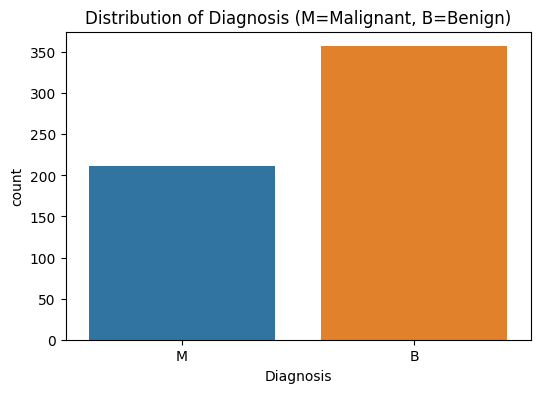

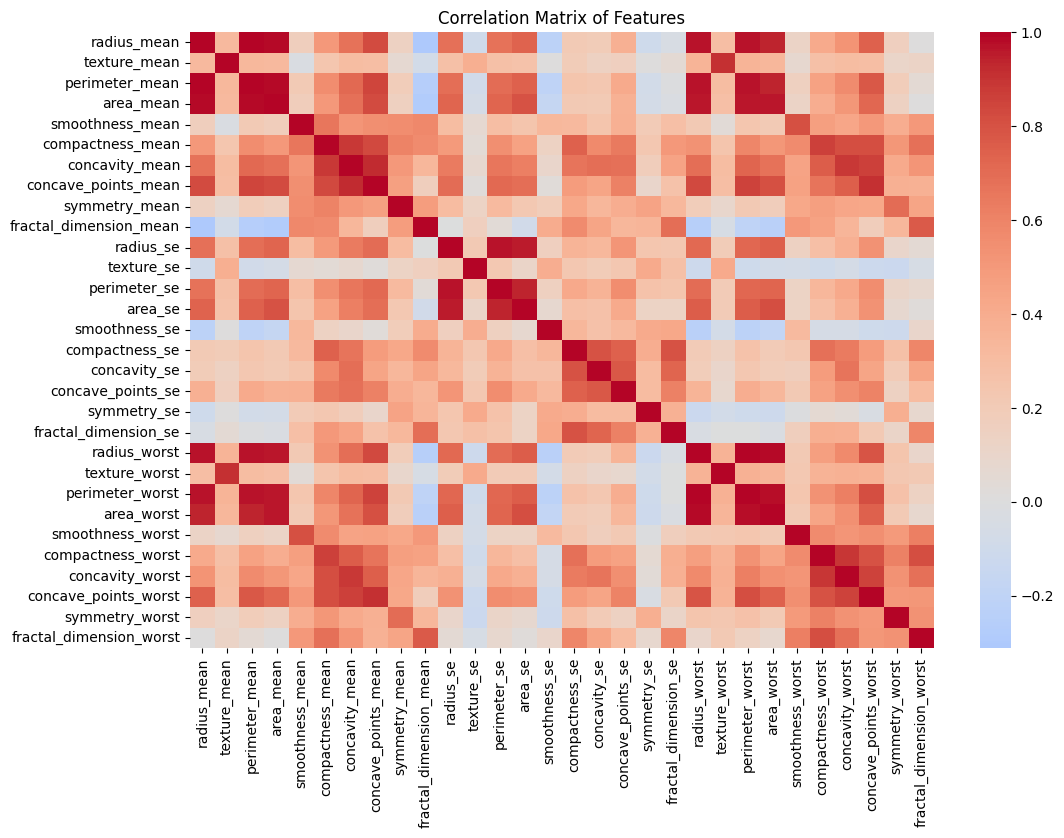

In [7]:
# Basic data information
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


# Visualize diagnosis distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Diagnosis', data=df)
plt.title('Distribution of Diagnosis (M=Malignant, B=Benign)')
plt.show()
plt.close()

# Correlation matrix
plt.figure(figsize=(12, 8))
numeric_cols = df.drop(['ID', 'Diagnosis'], axis=1)
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

# 3. Data Preprocessing
Transform the raw data into a format suitable for modeling, addressing class imbalance and feature relevance.

Ensures features are on a consistent scale, mitigates class imbalance to avoid bias toward the majority class, and reduces dimensionality by selecting the most predictive features.

In [8]:
# Convert diagnosis to binary (M=1, B=0)
df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})



# Split features and target
X = df.drop(['ID', 'Diagnosis'], axis=1)
y = df['Diagnosis']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_scaled_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test_scaled)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)

Selected Features: ['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave_points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst', 'concave_points_worst']


# 4. Model Training and Evaluation
Train multiple machine learning models to classify tumors, optimizing for performance and recall.
Develops a diverse set of models to compare performance and leverages ensemble methods to potentially improve predictions.

Assess model performance on the test set, focusing on accuracy, recall, and AUC-ROC for robust classification.

In [9]:
# 4. Model Training and Evaluation
# Initialize results dictionary
from sklearn.metrics import roc_auc_score

results = {'Model': [], 'Accuracy': [], 'AUC-ROC': [], 'Training Time': []}

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Support Vector Machine': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time()
    model.fit(X_train_selected, y_train_balanced)
    training_time = time() - start_time
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['AUC-ROC'].append(auc_roc)
    results['Training Time'].append(training_time)
    report_dict = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'], output_dict=True)
    report_str = (
        f"              precision    recall  f1-score   support\n"
        f"Benign      {report_dict['Benign']['precision']:.4f}  {report_dict['Benign']['recall']:.4f}  {report_dict['Benign']['f1-score']:.4f}  {report_dict['Benign']['support']:.4f}\n"
        f"Malignant   {report_dict['Malignant']['precision']:.4f}  {report_dict['Malignant']['recall']:.4f}  {report_dict['Malignant']['f1-score']:.4f}  {report_dict['Malignant']['support']:.4f}\n"
        f"accuracy                        {report_dict['accuracy']:.4f}       {report_dict['weighted avg']['support']:.4f}\n"
        f"macro avg   {report_dict['macro avg']['precision']:.4f}  {report_dict['macro avg']['recall']:.4f}  {report_dict['macro avg']['f1-score']:.4f}  {report_dict['weighted avg']['support']:.4f}\n"
        f"weighted avg {report_dict['weighted avg']['precision']:.4f}  {report_dict['weighted avg']['recall']:.4f}  {report_dict['weighted avg']['f1-score']:.4f}  {report_dict['weighted avg']['support']:.4f}"
    )
    print(f"\nClassification Report for {name}:")
    print(report_str)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Benign', 'Malignant'])
    plt.yticks([0.5, 1.5], ['Benign', 'Malignant'])
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png')
    plt.close()

# Tune KNN for recall
print("\nPerforming GridSearchCV for KNN (optimizing recall)...")
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_selected, y_train_balanced)
best_knn = grid_search.best_estimator_
print(f"Best KNN Parameters: {grid_search.best_params_}")
print(f"Best KNN Cross-Validation Recall: {grid_search.best_score_:.4f}")

# Evaluate tuned KNN
y_pred_knn = best_knn.predict(X_test_selected)
y_prob_knn = best_knn.predict_proba(X_test_selected)[:, 1]
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_auc_roc = roc_auc_score(y_test, y_prob_knn)
report_dict_knn = classification_report(y_test, y_pred_knn, target_names=['Benign', 'Malignant'], output_dict=True)
report_str_knn = (
    f"              precision    recall  f1-score   support\n"
    f"Benign      {report_dict_knn['Benign']['precision']:.4f}  {report_dict_knn['Benign']['recall']:.4f}  {report_dict_knn['Benign']['f1-score']:.4f}  {report_dict_knn['Benign']['support']:.4f}\n"
    f"Malignant   {report_dict_knn['Malignant']['precision']:.4f}  {report_dict_knn['Malignant']['recall']:.4f}  {report_dict_knn['Malignant']['f1-score']:.4f}  {report_dict_knn['Malignant']['support']:.4f}\n"
    f"accuracy                        {report_dict_knn['accuracy']:.4f}       {report_dict_knn['weighted avg']['support']:.4f}\n"
    f"macro avg   {report_dict_knn['macro avg']['precision']:.4f}  {report_dict_knn['macro avg']['recall']:.4f}  {report_dict_knn['macro avg']['f1-score']:.4f}  {report_dict_knn['weighted avg']['support']:.4f}\n"
    f"weighted avg {report_dict_knn['weighted avg']['precision']:.4f}  {report_dict_knn['weighted avg']['recall']:.4f}  {report_dict_knn['weighted avg']['f1-score']:.4f}  {report_dict_knn['weighted avg']['support']:.4f}"
)
print(f"\nTuned KNN Test Accuracy: {knn_accuracy:.4f}")
print(f"Tuned KNN Test AUC-ROC: {knn_auc_roc:.4f}")
print("\nClassification Report for Tuned K-Nearest Neighbors:")
print(report_str_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Tuned K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Benign', 'Malignant'])
plt.yticks([0.5, 1.5], ['Benign', 'Malignant'])
plt.savefig('confusion_matrix_Tuned_KNN.png')
plt.close()

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', models['Random Forest']),
        ('lr', models['Logistic Regression']),
        ('svm', models['Support Vector Machine']),
        ('knn', best_knn)
    ],
    voting='soft'
)
print("\nTraining Voting Classifier...")
start_time = time()
voting_clf.fit(X_train_selected, y_train_balanced)
voting_training_time = time() - start_time
y_pred_voting = voting_clf.predict(X_test_selected)
y_prob_voting = voting_clf.predict_proba(X_test_selected)[:, 1]
voting_accuracy = accuracy_score(y_test, y_pred_voting)
voting_auc_roc = roc_auc_score(y_test, y_prob_voting)
results['Model'].append('Voting Classifier')
results['Accuracy'].append(voting_accuracy)
results['AUC-ROC'].append(voting_auc_roc)
results['Training Time'].append(voting_training_time)
report_dict_voting = classification_report(y_test, y_pred_voting, target_names=['Benign', 'Malignant'], output_dict=True)
report_str_voting = (
    f"              precision    recall  f1-score   support\n"
    f"Benign      {report_dict_voting['Benign']['precision']:.4f}  {report_dict_voting['Benign']['recall']:.4f}  {report_dict_voting['Benign']['f1-score']:.4f}  {report_dict_voting['Benign']['support']:.4f}\n"
    f"Malignant   {report_dict_voting['Malignant']['precision']:.4f}  {report_dict_voting['Malignant']['recall']:.4f}  {report_dict_voting['Malignant']['f1-score']:.4f}  {report_dict_voting['Malignant']['support']:.4f}\n"
    f"accuracy                        {report_dict_voting['accuracy']:.4f}       {report_dict_voting['weighted avg']['support']:.4f}\n"
    f"macro avg   {report_dict_voting['macro avg']['precision']:.4f}  {report_dict_voting['macro avg']['recall']:.4f}  {report_dict_voting['macro avg']['f1-score']:.4f}  {report_dict_voting['weighted avg']['support']:.4f}\n"
    f"weighted avg {report_dict_voting['weighted avg']['precision']:.4f}  {report_dict_voting['weighted avg']['recall']:.4f}  {report_dict_voting['weighted avg']['f1-score']:.4f}  {report_dict_voting['weighted avg']['support']:.4f}"
)
print("\nClassification Report for Voting Classifier:")
print(report_str_voting)
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Benign', 'Malignant'])
plt.yticks([0.5, 1.5], ['Benign', 'Malignant'])
plt.savefig('confusion_matrix_Voting_Classifier.png')
plt.close()

# Cross-validation for all models
print("\nCross-Validation Recall Scores:")
for name, model in list(models.items()) + [('Tuned K-Nearest Neighbors', best_knn), ('Voting Classifier', voting_clf)]:
    scores = cross_val_score(model, X_train_selected, y_train_balanced, cv=5, scoring='recall')
    print(f"{name} Cross-Validation Recall: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support
Benign      0.9857  0.9718  0.9787  71.0000
Malignant   0.9545  0.9767  0.9655  43.0000
accuracy                        0.9737       114.0000
macro avg   0.9701  0.9743  0.9721  114.0000
weighted avg 0.9740  0.9737  0.9737  114.0000

Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support
Benign      0.9857  0.9718  0.9787  71.0000
Malignant   0.9545  0.9767  0.9655  43.0000
accuracy                        0.9737       114.0000
macro avg   0.9701  0.9743  0.9721  114.0000
weighted avg 0.9740  0.9737  0.9737  114.0000

Training Support Vector Machine...

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support
Benign      0.9718  0.9718  0.9718  71.0000
Malignant   0.9535  0.9535  0.9535  43.0000
accuracy                        0.9649       11

# 5. Compare Model Performance

Compare model performance to identify the best model for deployment.

Identifies the top-performing model and balances performance against computational cost.


Model Comparison:
                    Model  Accuracy   AUC-ROC  Training Time
0           Random Forest  0.973684  0.996069       0.284304
1     Logistic Regression  0.973684  0.998035       0.026371
2  Support Vector Machine  0.964912  0.997707       0.020103
3     K-Nearest Neighbors  0.973684  0.989355       0.003526
4       Voting Classifier  0.973684  0.997052       0.274136


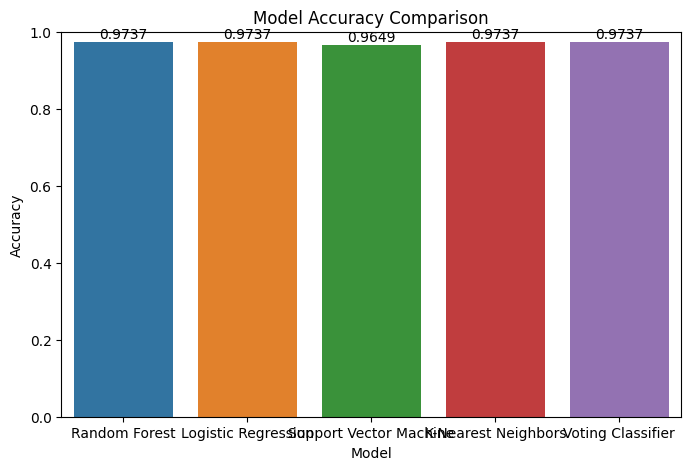

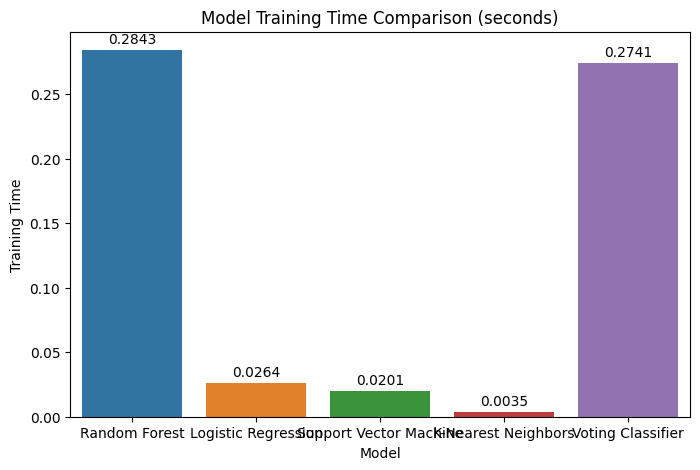

In [10]:

# Create a DataFrame for results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Visualize model accuracy
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for i, v in enumerate(results_df['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

# Visualize training time
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Training Time', data=results_df)
plt.title('Model Training Time Comparison (seconds)')
for i, v in enumerate(results_df['Training Time']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center')
plt.show()

# 6. Feature Importance (for Random Forest only)
Identify the most influential features for model predictions to enhance interpretability.

Highlights which features (e.g., concave_points_worst, radius_worst) drive predictions, aiding clinical understanding.

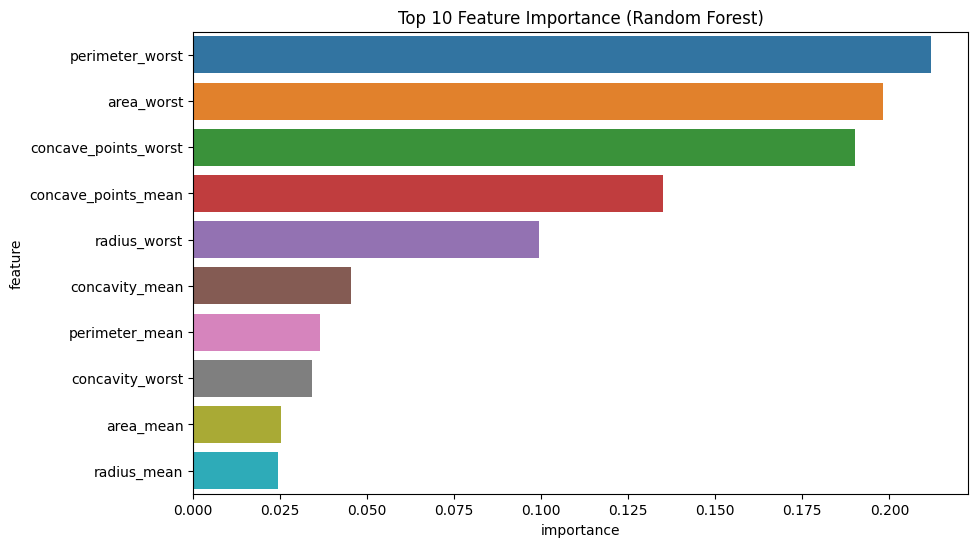

In [11]:
# Assuming selector is defined from the feature selection step
rf_model = models['Random Forest']
selected_feature_indices = selector.get_support()
selected_feature_names = X.columns[selected_feature_indices].tolist()

feature_importance = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance (Random Forest)')
plt.show()

# 7. Model Prediction Example
Demonstrate the practical application of the best model on new data.

In [12]:
# Find the best model based on accuracy
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# Make a prediction for a single sample using the selected features
sample = X_test_selected[0:1]  
prediction = best_model.predict(sample)
print(f"Sample Prediction: {'Malignant' if prediction[0] == 1 else 'Benign'}")


Best Model: Random Forest
Sample Prediction: Benign


In [ ]:
b# 8. Model Saving (save the best model and scaler)
from joblib import dump
dump(best_model, f'wdbc_{best_model_name.lower().replace(" ", "_")}_model.joblib')
dump(scaler, 'wdbc_scaler.pkl')

print("\nAnalysis complete! Best model and scaler saved.")


Analysis complete! Best model and scaler saved.


In [14]:
# Evaluate Model on New Unseen Data
from joblib import load
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report

# Manually specify the best model name (replace with the actual best model from your last run)
best_model_name = 'Random Forest'  # Example; change to 'Logistic Regression', 'SVM', etc., as needed

# Load the saved best model and scaler
best_model = load(f'wdbc_{best_model_name.lower().replace(" ", "_")}_model.joblib')
scaler = load('wdbc_scaler.pkl')

# Load and prepare new data from the provided dataset
new_data_df = pd.read_csv('data.csv')  # Load the CSV data
new_data_df['diagnosis'] = new_data_df['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to 0/1

# Define the correct feature order to match the original training data
feature_columns = [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
X_new = new_data_df[feature_columns].values  # Use only the 30 features in the correct order
y_new = new_data_df['diagnosis'].values  # Ground truth labels

# Preprocess new data (scale and select features)
X_new_scaled = scaler.transform(X_new)  # Scale the new data
selector = SelectKBest(score_func=f_classif, k=10)  # Reinitialize with same k
selector.fit(X_train_scaled_balanced, y_train_balanced)  # Use original training data to get feature indices
X_new_selected = selector.transform(X_new_scaled)

# Make predictions
predictions = best_model.predict(X_new_selected)
prediction_probs = best_model.predict_proba(X_new_selected)

# Output results
print(f"\nEvaluating {best_model_name} on new unseen data:")
for i, (pred, prob) in enumerate(zip(predictions, prediction_probs)):
    print(f"Sample {i+1} (ID: {new_data_df['id'].iloc[i]}): Predicted {'Malignant' if pred == 1 else 'Benign'}, "
          f"Probabilities: Benign={prob[0]:.4f}, Malignant={prob[1]:.4f}")

# Evaluate performance with ground truth labels
accuracy = accuracy_score(y_new, predictions)
report_dict = classification_report(y_new, predictions, target_names=['Benign', 'Malignant'], output_dict=True)
report_str = (
    f"              precision    recall  f1-score   support\n"
    f"Benign      {report_dict['Benign']['precision']:.4f}  {report_dict['Benign']['recall']:.4f}  {report_dict['Benign']['f1-score']:.4f}  {report_dict['Benign']['support']:.4f}\n"
    f"Malignant   {report_dict['Malignant']['precision']:.4f}  {report_dict['Malignant']['recall']:.4f}  {report_dict['Malignant']['f1-score']:.4f}  {report_dict['Malignant']['support']:.4f}\n"
    f"accuracy                        {report_dict['accuracy']:.4f}       {report_dict['weighted avg']['support']:.4f}\n"
    f"macro avg   {report_dict['macro avg']['precision']:.4f}  {report_dict['macro avg']['recall']:.4f}  {report_dict['macro avg']['f1-score']:.4f}  {report_dict['weighted avg']['support']:.4f}\n"
    f"weighted avg {report_dict['weighted avg']['precision']:.4f}  {report_dict['weighted avg']['recall']:.4f}  {report_dict['weighted avg']['f1-score']:.4f}  {report_dict['weighted avg']['support']:.4f}"
)
print(f"\nPerformance on New Data:")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report_str)


Evaluating Random Forest on new unseen data:
Sample 1 (ID: 842302): Predicted Malignant, Probabilities: Benign=0.0000, Malignant=1.0000
Sample 2 (ID: 842517): Predicted Malignant, Probabilities: Benign=0.0000, Malignant=1.0000
Sample 3 (ID: 84300903): Predicted Malignant, Probabilities: Benign=0.0000, Malignant=1.0000
Sample 4 (ID: 84348301): Predicted Malignant, Probabilities: Benign=0.0500, Malignant=0.9500
Sample 5 (ID: 84358402): Predicted Malignant, Probabilities: Benign=0.0000, Malignant=1.0000
Sample 6 (ID: 843786): Predicted Malignant, Probabilities: Benign=0.0600, Malignant=0.9400
Sample 7 (ID: 844359): Predicted Malignant, Probabilities: Benign=0.0000, Malignant=1.0000
Sample 8 (ID: 84458202): Predicted Malignant, Probabilities: Benign=0.0000, Malignant=1.0000
Sample 9 (ID: 844981): Predicted Malignant, Probabilities: Benign=0.0200, Malignant=0.9800
Sample 10 (ID: 84501001): Predicted Malignant, Probabilities: Benign=0.1200, Malignant=0.8800
Sample 11 (ID: 845636): Predicted

/home/ambroz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
